In [ ]:
!pip install transformers[torch]==4.19.2 shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.1
    Uninstalling tokenizers-0.15.1:
      Successfully uninstalled tokenizers-0.15.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
import numpy as np
import shap
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ",device)
seed = 42
np.random.seed(seed)

Device available:  cpu


In [ ]:
# Trained Model
distilbert_model_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/model/distilbert_unprocessed_v1.pth'
# Input Data
data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_distilbert_input_unprocessed.pkl'
# DistilBERT Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
# Temperature
TEMP = 0.75

model = torch.load(distilbert_model_path)
class_names = ['not distinct','distinct']

In [ ]:
# Function to generate batches and reshape
def batching(np_array, max_idx, batch_size):
    np_array = np_array[:max_idx]
    np_array = np_array.reshape(-1, batch_size)
    batched_list = np_array.tolist()
    return batched_list

In [ ]:
# Temperature Scaling
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

In [ ]:
# Predictor function for SHAP - takes list of strings as input
def predictor_shap(text_list):
    X = batching(np.array(text_list), max_idx=len(text_list), batch_size=1)
    pred_prob = []
    pred_logits = []
    model.eval()
    with torch.no_grad():
        for text in tqdm(X, total=len(X)):
            model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
            output = model(**model_inputs)
            logits = output[0]
            logits = T_scaling(logits, {'temperature':TEMP})
            probs = torch.sigmoid(logits)
            pred_prob.extend(probs[:,1].tolist())
    return pred_prob

In [ ]:
# Takes single text input
def predictor_lime(text:str):
    #X = batching(np.array([text]), max_idx=1, batch_size=1)
    pred_prob = []
    pred_logits = []
    model.eval()
    with torch.no_grad():
        model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
        output = model(**model_inputs)
        logits = output[0]
        logits = T_scaling(logits, {'temperature':TEMP})
        probs = torch.sigmoid(logits).detach().cpu().numpy()
    return probs

In [ ]:
def preprocess(input_text):
  text = input_text.replace("[SEP]", "")
  text = text.replace("[CLS]", "")
  return text

In [ ]:
# Function for predicting y
def bert_pred(model_path, X, y, tokenizer, th=0.5, temp=None):
    loaded_model = torch.load(model_path)
    predictions, targets = [], []
    pred_prob = []
    loaded_model.eval()
    with torch.no_grad():
        for text, labels in tqdm(zip(X, y), total=len(X)):
            #try:
            model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
            output = loaded_model(**model_inputs)
            logits = output[0]
            if temp is not None:
                logits = T_scaling(logits, {'temperature':temp})
            probs = torch.sigmoid(logits)
            pred_prob.extend(probs[:,1].tolist())
            if th==0.5:
                # prediction is the argmax of the logits
                predictions.extend(logits.argmax(dim=1).tolist())
            else:
                predictions.extend(((probs[:,1]>=th)*1).tolist())
            targets.extend(labels)
            #except:
            #    print("Unable to process: ", text)
            #    continue
    return targets, pred_prob, predictions

In [ ]:
df = pd.read_pickle(data_path)
df['filing_dt'] = pd.to_datetime(df['filing_dt'])
df["bert_input_unprocessed"] = df["bert_input_unprocessed"].apply(lambda x: preprocess(x))

# Divide data into train, test and validation
df_train = df[(df['filing_dt']>=pd.to_datetime('2012-01-01')) & (df['filing_dt']<=pd.to_datetime('2017-12-31'))]
df_val = df[(df['filing_dt']>=pd.to_datetime('2018-01-01')) & (df['filing_dt']<=pd.to_datetime('2018-12-31'))]
df_test = df[(df['filing_dt']>=pd.to_datetime('2019-01-01')) & (df['filing_dt']<=pd.to_datetime('2019-12-31'))]
print("Train data shape: ", df_train.shape)
print("Validation data shape: ", df_val.shape)
print("Test data shape: ", df_test.shape)

zipscene_text = list(df[df['mark_final']=='ZIPSCENE']['bert_input_unprocessed'])[0]

Train data shape:  (1001779, 22)
Validation data shape:  (234752, 22)
Test data shape:  (264827, 22)


### Sample BERT Predictions

In [ ]:
### Get sample predictions
# X_test
X_test = np.array(df['bert_input_unprocessed'][:100])
# y_test
y_test = np.array(df['distinct_ind'][:100])


batch_size = 20
# Batching
test_max_idx = batch_size * (len(X_test)//batch_size)
X_test = batching(X_test, test_max_idx, batch_size=batch_size)
y_test = batching(y_test, test_max_idx, batch_size=batch_size)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# With temperature
labels, pred_prob_temp, predictions = bert_pred(distilbert_model_path, X_test, y_test, tokenizer, temp=TEMP)


100%|██████████| 5/5 [00:00<00:00, 15.11it/s]


In [ ]:
df_predictions = pd.DataFrame({'true_label':labels, 'probs':pred_prob_temp, 'pred':predictions})
df_predictions

,true_label,probs,pred
0,1,0.897088,1
1,0,0.352326,0
2,1,0.844919,1
3,1,0.829034,1
4,1,0.898444,1
...,...,...,...
95,1,0.883371,1
96,1,0.844569,1
97,1,0.814480,1
98,1,0.693455,1


In [ ]:
df_predictions[(df_predictions['probs']>0.5) & (df_predictions['probs']<0.6)]

,true_label,probs,pred
11,0,0.550009,1
39,1,0.545481,1
42,0,0.532123,1
49,1,0.569773,1
88,1,0.593485,1
92,1,0.541150,1


In [ ]:
df.iloc[92]['bert_input_unprocessed']

' BEEP & BOOP  Interactive educational and entertainment services, namely, an online activity that provides recognition and incentives to children for learning and good behavior through the issuance of awards  no translation required  mark present in Wordnet  mark length is 2  NICE category is 41  Education; Providing of training; Entertainment; Sporting and cultural activities  Pseudo mark is BEEP AND BOOP'

In [ ]:
beep_text = df.iloc[92]['bert_input_unprocessed']

### SHAP

In [ ]:
## Function to get word level scores from SHAP

def get_word_level_scores(shap_values, text, idx=0):
  # Strip text
  text = text.strip()
  # Split text
  text_split = text.split()
  # Will have word level scores
  word_level_scores = []
  # Subwords and corresponding scores from SHAP
  subwords = shap_values.data[idx]
  subword_scores = shap_values.values[idx]
  nsubwords = shap_values.data[idx].shape[0]
  # Iterator for word in text
  word_counter = 0
  # Initialize current subword, number of subwords needed to make a word and word score
  curr_subword = ''
  nsub = 0
  word_score = 0
  for i in range(nsubwords):
    # Don't consider empty string
    if subwords[i]==' ':
      continue
    # If subword matches current text word, append to list
    if curr_subword.strip() == text_split[word_counter].strip():
      word_level_scores.append((text_split[word_counter], word_score/nsub))
      word_counter += 1
      nsub = 0
      curr_subword = ''
      word_score = 0
    # Concatenate subwords
    curr_subword += subwords[i]
    word_score += subword_scores[i]
    nsub += 1

  assert(len(word_level_scores)==len(text_split))
  return word_level_scores

In [ ]:
from IPython.display import HTML

def highlight_words(wordlevel_scores):
  words = [x[0] for x in wordlevel_scores]
  scores = [x[1] for x in wordlevel_scores]
  maxscore = max(scores)
  minscore = min(scores)
  normscores = [(x-minscore)/(maxscore-minscore) for x in scores]

  # Create HTML content with words highlighted based on numeric values
  html_content = "<p>"
  for word, value in zip(words, normscores):
      color = f"rgba(0, {int(255 * value)}, 0, 0.5)"
      html_content += f'<span style="background-color: {color};">{word} </span>'
  html_content += "</p>"

  # Explanation for colors and colormap legend
  explanation = "<p>Explanation for colors:</p>"
  explanation += "<ul>"
  explanation += "<li>Words with high numeric values have a color closer to green.</li>"
  explanation += "</ul>"

  # Display the HTML content, explanation, and colormap legend in the notebook
  display(HTML(explanation))
  display(HTML(html_content))


In [ ]:
def plot_bar(wordlevel_scores, topk=5):
  sorted_scores = sorted(wordlevel_scores, key=lambda tup: tup[1], reverse=True)
  # Convert to percentage
  allsum = sum(x[1] for x in sorted_scores)
  perc = [100*x[1]/allsum for x in sorted_scores]
  # Select top-k words and percentage
  topk_scores = perc[:topk]
  topk_words = [x[0] for x in sorted_scores[:topk]]
  y_pos = np.arange(len(topk_words))
  # Bar plot
  plt.barh(y_pos, list(reversed(topk_scores)), align='center')
  plt.yticks(y_pos, list(reversed(topk_words)))
  plt.xlabel('Top {k} Word Level Attribution in Percentage'.format(k=topk))
  plt.show()


In [ ]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

### SHAP for ZIPSCENE

In [ ]:
shap_explainer = shap.Explainer(predictor_shap, tokenizer, silent=True)
# shap_values = shap_explainer([zipscene_text], fixed_context=1)
shap_values = shap_explainer([zipscene_text], silent=True)

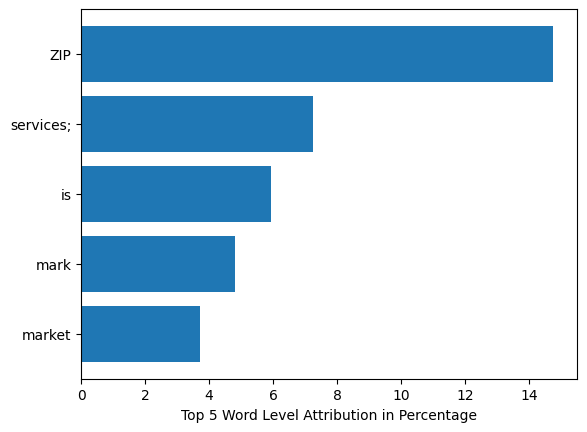

In [ ]:
wordlevel_scores = get_word_level_scores(shap_values, zipscene_text)
highlight_words(wordlevel_scores)
plot_bar(wordlevel_scores)

In [ ]:
%%capture

mod_zipscene_text = """
ZIPSCENE  Marketing and market research services;
Analyzing and compiling business and marketing data,
namely, data assembly, integrations, and analysis relating to
customer behavior and transactions;
Customer relationship consultation, namely, developing strategies and programs for
communicating with customers
no translation required  mark absent in Wordnet  mark length is 1
NICE category is 35
Advertising; Business management, organization and administration; Office functions
Pseudo mark is SCENE

"""
shap_explainer = shap.Explainer(predictor_shap, tokenizer, silent=False)
mod_shap_values = shap_explainer([mod_zipscene_text], silent=True)
shap.plots.text(mod_shap_values[0])


In [ ]:
wordlevel_scores

[('ZIPSCENE', 0.00406168509008629),
 ('Marketing', 0.009056124237499066),
 ('and', 0.009056124237499066),
 ('market', 0.02104797861206212),
 ('research', 0.02104797861206212),
 ('services;', 0.041163390918102644),
 ('Analyzing', 0.01411816422339706),
 ('and', 0.0071883137515258225),
 ('compiling', 0.005808611744127813),
 ('business', 0.005808611744127813),
 ('and', 0.016563424175339087),
 ('marketing', 0.0063517398999205655),
 ('data,', 0.005999789606513721),
 ('namely,', 0.002737451686213414),
 ('data', 0.004210156264404455),
 ('assembly,', 0.004210156264404455),
 ('integrations,', 0.0028555349757273993),
 ('and', 0.0014828478340946493),
 ('analysis', 0.0014828478340946493),
 ('relating', 0.0014828478340946493),
 ('to', 0.0014828478340946493),
 ('customer', 0.0014828478340946493),
 ('behavior', 0.0014828478340946493),
 ('and', 0.001097490999936348),
 ('transactions;', 0.001097490999936348),
 ('Customer', 0.001097490999936348),
 ('relationship', 0.001097490999936348),
 ('consultation,'



### SHAP for NICE Class

In [ ]:
def get_all_word_attr(text_list):
  # Get SHAP values for all inputs
  shap_explainer = shap.Explainer(predictor_shap, tokenizer, silent=True)
  shap_values = shap_explainer(text_list, fixed_context=1, silent=True)
  all_word_attr = []
  for i in range(len(text_list)):
    word_attr = get_word_level_scores(shap_values, text_list[i], i)
    all_word_attr.append(word_attr)
  return all_word_attr

In [ ]:
## Get a dictionary of words/tokens and their average scores
def build_attr_dict(word_attr_all):
  word_attr_dict = dict()
  word_freq_dict = dict()
  for word_attr in word_attr_all:
    for word, score in word_attr:
      if word in word_attr_dict:
        word_attr_dict[word] += score
        word_freq_dict[word] += 1
      else:
        word_attr_dict[word] = score
        word_freq_dict[word] = 1

  for word, score in word_attr_dict.items():
    word_attr_dict[word] = word_attr_dict[word]/word_freq_dict[word]

  return word_attr_dict

In [ ]:
## Build wordcloud from word attr scores

def build_wordcloud(word_attr_dict, pos=True):
  wordcloud = WordCloud(width=800, height=400, background_color='white')
  if pos:
    wordcloud.generate_from_frequencies(word_attr_dict)
  else:
    for word, score in word_attr_dict.items():
      word_attr_dict[score] = -1 * word_attr_dict[score]
    wordcloud.generate_from_frequencies(word_attr_dict)

  plt.figure(figsize=(12,6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()



### NICE Classes to take - 12, 16, 25, 32, 33, 34 and 43

In [ ]:
def dump_nice_word_attr(df_test, nclass):
  df_nice = df_test[df_test['nice_cat_text']=='NICE category is ' +str(nclass)].copy()
  text_list = df_nice['bert_input_unprocessed'].tolist()
  all_word_attr =  get_all_word_attr(text_list)
  word_attr_dict = build_attr_dict(all_word_attr)
  save_loc = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/shap_scores_nice_class_{f}.pkl'.format(f=nclass)
  with open(save_loc, 'wb') as handle:
    pickle.dump(word_attr_dict, handle)



In [ ]:
nice_classes = [12, 16, 32, 33, 34, 43] # Do 25 later
# Check Shape
for nclass in nice_classes:
  nrows = df_test[df_test['nice_cat_text']=='NICE category is ' +str(nclass)].shape[0]
  print(nclass)
  print("Num rows: ", nrows)
  print("Expected time (min): ", nrows/50)

12
Num rows:  3890
Expected time (min):  77.8
16
Num rows:  5785
Expected time (min):  115.7
32
Num rows:  4166
Expected time (min):  83.32
33
Num rows:  6839
Expected time (min):  136.78
34
Num rows:  1940
Expected time (min):  38.8
43
Num rows:  6019
Expected time (min):  120.38


In [ ]:
## NICE Class 34
from time import time
start = time()
dump_nice_word_attr(df_test, 34)
end = time()
print("Time taken: ", (end-start)/60)

Streaming output truncated to the last 5000 lines.
100%|██████████| 6/6 [00:00<00:00, 109.96it/s]

In [ ]:
%%capture
## NICE Class 12
from time import time
start = time()
dump_nice_word_attr(df_test, 12)
end = time()
torch.cuda.empty_cache()

Token indices sequence length is longer than the specified maximum sequence length for this model (1676 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print("Time taken: ", (end-start)/60)

Time taken:  118.32305340766906


In [ ]:
%%capture
## NICE Class 16
from time import time
start = time()
dump_nice_word_attr(df_test, 16)
end = time()
torch.cuda.empty_cache()

In [ ]:
print("Time taken: ", (end-start)/60)

Time taken:  236.29340677658718


In [ ]:
%%capture
## NICE Class 32
from time import time
start = time()
dump_nice_word_attr(df_test, 32)
end = time()
torch.cuda.empty_cache()

In [ ]:
print("Time taken: ", (end-start)/60)

Time taken:  93.52765061457951


In [ ]:
%%capture
## NICE Class 43
from time import time
start = time()
dump_nice_word_attr(df_test, 43)
end = time()
torch.cuda.empty_cache()

In [ ]:
print("Time taken: ", (end-start)/60)

Time taken:  106.22291929324469


### Get tables for top 5-10 words for each NICE Class with their attribution scores

In [ ]:
import pickle
import pandas as pd
from operator import itemgetter

save_loc = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/shap_scores_nice_class_{f}.pkl'


In [ ]:
import string

def get_topk_vals(input_dict,nclass,df=df_test,topk=10,special_words=[]):
  res = dict(sorted(input_dict[nclass].items(), key=itemgetter(1), reverse=True)[:topk])
  print(res)

  df_ncls = df[df['nice_cat_text']=='NICE category is ' +str(nclass)].copy()
  mark_list = df_ncls['mark_unprocessed'].tolist()
  original_mark = []
  for mk, val in res.items():
    mk_list = []
    for i, mark in enumerate(mark_list):
      if mk in mark.split():
        mk_list.append(mark)

    if len(mk_list)==0:
      new_mk = mk.translate(str.maketrans('', '', string.punctuation)).strip()
      for i,mark in enumerate(mark_list):
        if mk in mark.split():
          mk_list.append(mark)

    original_mark.append(mk_list)


  mark_res = []
  attr_res = []
  for mk,val in res.items():
    mark_res.append(mk)
    attr_res.append(val)
  df_res = pd.DataFrame({'word':mark_res, 'attr':attr_res, 'mark':original_mark})

  if len(special_words)>0:
    for word in special_words:
      for mark in mark_list:
        if word in mark.split():
          print(word, mark)

  return df_res

In [ ]:
### Load all pickle files
nclasses = [12, 16, 32, 43]
ncattr_dict = dict()
for nclass in nclasses:
  with open(save_loc.format(f=nclass), 'rb') as handle:
    ncattr_dict[nclass] = pickle.load(handle)


In [ ]:
## NICE Class 12
df_res12 = get_topk_vals(ncattr_dict, 12, special_words=["CUSTOM","SMART"])
print(df_res12)

{'VIVA': 0.14409572448013191, 'III': 0.13826482075375396, 'GET': 0.13623963021157043, "A'": 0.12519464364987698, '"CUSTOM': 0.11533829560764315, '369': 0.11491134451202689, 'GOT': 0.11110067326468989, 'II': 0.10932499367859186, '"SMART': 0.1075520378416416, 'ACE': 0.10558717070341805}
CUSTOM CUSTOM WHEEL HOUSE
CUSTOM CAYO CUSTOM BOATS
SMART SMART CLAMP
SMART SMART EAGLE
SMART SMART TYRE CONCEPT
SMART SMART LEAN TECHNOLOGY
SMART POWERSTEP SMART SERIES
SMART SMART STEP
SMART SMART WARMERS
      word      attr                          mark
0     VIVA  0.144096             [VIVA LA CROTCH!]
1      III  0.138265                     [BIN III]
2      GET  0.136240                 [GET UNSTUCK]
3       A'  0.125195                  [A' LA CART]
4  "CUSTOM  0.115338                            []
5      369  0.114911                 [ONENESS 369]
6      GOT  0.111101         [SHIFT JUST GOT REAL]
7       II  0.109325  [MACH II, BRONCO II, SEE II]
8   "SMART  0.107552                            [

In [ ]:
## NICE Class 16
df_res16 = get_topk_vals(ncattr_dict, 16)
print(df_res16)

{'360': 0.4441307368758776, '=': 0.24776424879659553, 'MB': 0.18388313945484852, 'JZ': 0.18373024158387835, 'WAD': 0.16398504583584128, 'NRP': 0.15887874901566923, '|': 0.1445928160156292, 'HJ': 0.14050861539478898, 'NEE': 0.14011070888464142, 'VIZ': 0.13868222779904804}
  word      attr                                               mark
0  360  0.444131                   [AWARENESS 360 SITUATION REPORT]
1    =  0.247764  [REFLECTION + INSPECTION = NEW DIRECTION, EFFE...
2   MB  0.183883                                   [MB COUPON BOOK]
3   JZ  0.183730                                       [JZ DESIGNS]
4  WAD  0.163985                                     [BROCCOLI WAD]
5  NRP  0.158879                 [NRP NATIONAL REGISTER PUBLISHING]
6    |  0.144593  [PROGRESSIVE HEALTH | WISE PREVENTION, SEL | S...
7   HJ  0.140509                                       [HJ DESIGNS]
8  NEE  0.140111                                     [WATCHMAN NEE]
9  VIZ  0.138682                                

In [ ]:
## NICE Class 32
df_res32 = get_topk_vals(ncattr_dict, 32)
print(df_res32)

{'Z': 0.1535823424581042, 'BSD': 0.1436856165293115, '74': 0.12923078357056006, 'TY': 0.12740656941666573, 'III': 0.12232456725356011, 'MEETS': 0.12048702031518171, 'ME!': 0.11722590408470492, 'BLAST': 0.11637346339600219, 'GETTER': 0.1068674499216328, 'BORA': 0.10597913135407548}
     word      attr                       mark
0       Z  0.153582                  [HUPER Z]
1     BSD  0.143686                 [PLNT BSD]
2      74  0.129231       [BIOACTIVE WATER 74]
3      TY  0.127407               [TY WINE ON]
4     III  0.122325                 [TIER III]
5   MEETS  0.120487  [BEER MEETS EXOTIC FRUIT]
6     ME!  0.117226   [CLEANSE ME!, POWER ME!]
7   BLAST  0.116373           [GATORADE BLAST]
8  GETTER  0.106867   [GLOW GETTER, GO GETTER]
9    BORA  0.105979                [AURA BORA]


In [ ]:
## NICE Class 32
df_res32 = get_topk_vals(ncattr_dict, 32)
print(df_res32)